In [ ]:
%%capture
import torch

# 1. Unsloth'u Ana Paket Olarak Kur
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# 2. KRİTİK ADIM: Xformers'ı Hazır Paket (Binary) Olarak Zorla Yükle
# Bu satır "Building wheels" hatasını engeller.
!pip install xformers --index-url https://download.pytorch.org/whl/cu121 --no-deps

# 3. Diğerlerini versiyon kontrolü yapmadan hızlıca kur
!pip install --no-deps "trl<0.9.0" peft accelerate bitsandbytes

In [ ]:
import torch
from unsloth import FastLanguageModel
from safetensors.torch import load_file, save_file
import json
from tqdm import tqdm
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import gc
from google.colab import drive

# 1. HAZIRLIK VE DRIVE BAĞLANTISI
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/Proje_Yedekleri"

# Kayıtlı Model Yolları
models = {
    "Matematik": f"{base_path}/model_matematik_uzmani",
    "Kimya":     f"{base_path}/model_kimya_uzmani",
    "Fizik":     f"{base_path}/model_fizik_uzmani"
}

output_dir = "merged_fen_bilimleri_adapter"

# ========================================================
# ADIM 1: MERGE (MODEL SOUPS - AĞIRLIK ORTALAMASI)
# ========================================================
def simple_average_merge(model_paths, output_path):
    print(f"\n🥣 MERGE İŞLEMİ BAŞLIYOR: {list(model_paths.keys())}")

    # 1. Config dosyasını kopyala
    first_model_path = list(model_paths.values())[0]
    if os.path.exists(output_path): shutil.rmtree(output_path)
    os.makedirs(output_path)
    shutil.copy(f"{first_model_path}/adapter_config.json", f"{output_path}/adapter_config.json")

    # 2. Ağırlıkları Yükle
    loaded_weights = []
    for name, path in model_paths.items():
        w_path = f"{path}/adapter_model.safetensors"
        if os.path.exists(w_path):
            print(f"   📂 {name} ağırlıkları okunuyor...")
            loaded_weights.append(load_file(w_path))
        else:
            print(f"⚠️ UYARI: {name} modeli bulunamadı, merge işlemine dahil edilemiyor!")

    if not loaded_weights:
        raise FileNotFoundError("❌ Hiçbir model bulunamadı!")

    # 3. Ortalamasını Al
    print("   ⚖️ Parametrelerin ortalaması alınıyor...")
    merged_state_dict = {}
    ref_keys = loaded_weights[0].keys()

    for key in ref_keys:
        # Tensörleri topla ve model sayısına böl
        sum_tensor = sum(w[key] for w in loaded_weights)
        avg_tensor = sum_tensor / len(loaded_weights)
        merged_state_dict[key] = avg_tensor

    # 4. Kaydet
    save_file(merged_state_dict, f"{output_path}/adapter_model.safetensors")
    print(f"✅ BİRLEŞTİRME TAMAMLANDI: {output_path}")

# Merge İşlemini Yap
simple_average_merge(models, output_dir)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
Mounted at /content/drive

🥣 MERGE İŞLEMİ BAŞLIYOR: ['Matematik', 'Kimya', 'Fizik']
   📂 Matematik ağırlıkları okunuyor...
   📂 Kimya ağırlıkları okunuyor...
   📂 Fizik ağırlıkları okunuyor...
   ⚖️ Parametrelerin ortalaması alınıyor...
✅ BİRLEŞTİRME TAMAMLANDI: merged_fen_bil

In [ ]:
# ========================================================
# ADIM 2: MODELİ YÜKLE
# ========================================================
# Hafıza Temizliği
try:
    del model
    del tokenizer
    gc.collect()
    torch.cuda.empty_cache()
except: pass

print("\n🧠 Fen Bilimleri Kolektif Modeli Yükleniyor...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = output_dir, # Merge edilen klasör
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
FastLanguageModel.for_inference(model)


🧠 Fen Bilimleri Kolektif Modeli Yükleniyor...
==((====))==  Unsloth 2026.1.4: Fast Llama patching. Transformers: 4.57.6.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Unsloth 2026.1.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lor

In [ ]:
# ========================================================
# ADIM 3: 3'LÜ TEST (MAT, KIM, FIZ)
# ========================================================
def run_exam(subject_name, file_path, model, tokenizer):
    if not os.path.exists(file_path):
        print(f"⚠️ {subject_name} testi bulunamadı: {file_path}")
        return 0

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    print(f"\n🚀 {subject_name} Testi Başlıyor ({len(data)} Soru)...")

    correct = 0
    BATCH_SIZE = 16

    prompt_temp = """Aşağıdaki soruyu çöz.
### Soru:
{}
### Seçenekler:
{}
### Çözüm ve Cevap:
"""
    batches = [data[i:i + BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]

    for batch in tqdm(batches, desc=subject_name):
        texts = []
        truths = []
        for item in batch:
            opts = item.get("options", [])
            opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)
            texts.append(prompt_temp.format(item["question"], opts_str))
            truths.append(str(item["correct"]).strip().upper())

        inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=512, pad_token_id=tokenizer.eos_token_id)

        decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for i, text in enumerate(decoded):
            gen_text = text.replace(texts[i], "").strip()
            # Gelişmiş Regex
            match = re.search(r"(?:Cevap|Seçenek|Yanıt|Doğru Cevap)[:\s-]*([A-E])", gen_text, re.IGNORECASE)
            if match:
                ans = match.group(1).upper()
            else:
                # Son çare: Metnin son harfi
                clean = gen_text.strip()
                ans = clean[-1].upper() if clean and clean[-1].upper() in "ABCDE" else "Boş"

            if ans == truths[i]: correct += 1

    score = (correct / len(data)) * 100
    print(f"👉 {subject_name} Skoru: %{score:.2f}")
    return score

# --- TEST DOSYALARI (GÜNCELLENDİ) ---
test_files = {
    "Matematik": f"{base_path}/mat_test.json",  # <--- GÜNCELLENDİ
    "Kimya":     f"{base_path}/kimya_test.json",
    "Fizik":     f"{base_path}/fizik_test.json"
}

final_scores = {}
for subject, path in test_files.items():
    score = run_exam(subject, path, model, tokenizer)
    final_scores[subject] = score


🚀 Matematik Testi Başlıyor (100 Soru)...


Matematik: 100%|██████████| 7/7 [04:14<00:00, 36.37s/it]


👉 Matematik Skoru: %34.00

🚀 Kimya Testi Başlıyor (100 Soru)...


Kimya: 100%|██████████| 7/7 [02:50<00:00, 24.38s/it]


👉 Kimya Skoru: %39.00

🚀 Fizik Testi Başlıyor (100 Soru)...


Fizik: 100%|██████████| 7/7 [02:18<00:00, 19.78s/it]

👉 Fizik Skoru: %37.00


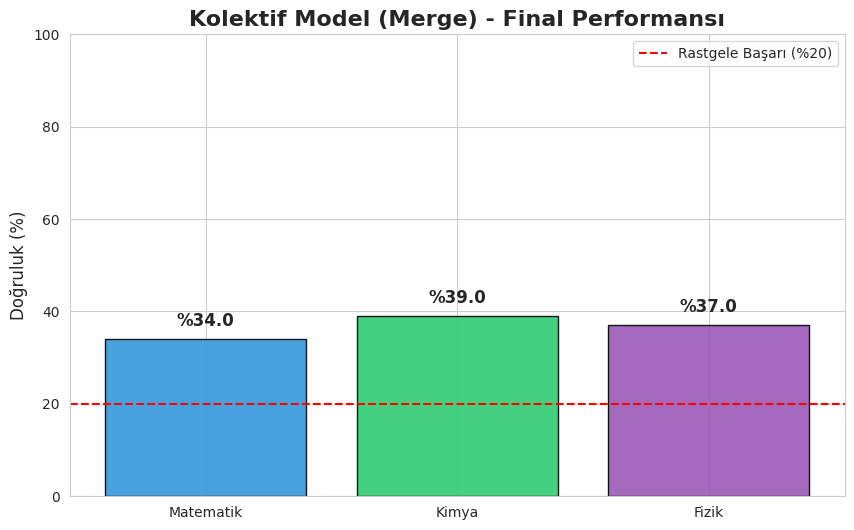

✅ Grafik Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Final_Merge_Basari_Grafigi.png

💾 Merge Edilmiş Model Drive'a Yedekleniyor...
🎉 BÜYÜK FİNAL TAMAMLANDI!
📂 Modelin Yeri: /content/drive/MyDrive/Proje_Yedekleri/FEN_BILIMLERI_FINAL_MODEL


In [ ]:
# ========================================================
# ADIM 4: GRAFİKLEŞTİR VE KAYDET
# ========================================================
# 1. Grafik Çiz
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

colors = ['#3498db', '#2ecc71', '#9b59b6'] # Mavi, Yeşil, Mor
subjects = list(final_scores.keys())
scores = list(final_scores.values())

bars = plt.bar(subjects, scores, color=colors, edgecolor='black', alpha=0.9)

plt.title('Kolektif Model (Merge) - Final Performansı', fontsize=16, fontweight='bold')
plt.ylabel('Doğruluk (%)', fontsize=12)
plt.ylim(0, 100)
plt.axhline(y=20, color='red', linestyle='--', label='Rastgele Başarı (%20)')
plt.legend()

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 2, f'%{height:.1f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

# 2. Grafiği Drive'a Kaydet
graph_path = f"{base_path}/Final_Merge_Basari_Grafigi.png"
plt.savefig(graph_path, dpi=300)
plt.show()
print(f"✅ Grafik Kaydedildi: {graph_path}")

# 3. Modeli Drive'a Yedekle (Kalıcı Klasör)
print("\n💾 Merge Edilmiş Model Drive'a Yedekleniyor...")
final_model_name = "FEN_BILIMLERI_FINAL_MODEL"
dest_path = f"{base_path}/{final_model_name}"

model.save_pretrained(final_model_name)
tokenizer.save_pretrained(final_model_name)

if os.path.exists(dest_path): shutil.rmtree(dest_path)
shutil.copytree(final_model_name, dest_path)

print(f"🎉 BÜYÜK FİNAL TAMAMLANDI!")
print(f"📂 Modelin Yeri: {dest_path}")

🕵️‍♂️ DETAYLI ANALİZ BAŞLIYOR...

📘 Matematik Analiz Ediliyor (100 Soru)...


Matematik: 100%|██████████| 7/7 [03:46<00:00, 32.42s/it]


📘 Kimya Analiz Ediliyor (100 Soru)...


Kimya: 100%|██████████| 7/7 [03:23<00:00, 29.09s/it]


📘 Fizik Analiz Ediliyor (100 Soru)...


Fizik: 100%|██████████| 7/7 [02:10<00:00, 18.59s/it]



💾 Detaylı Rapor Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Fen_Bilimleri_Detayli_Hata_Raporu.xlsx


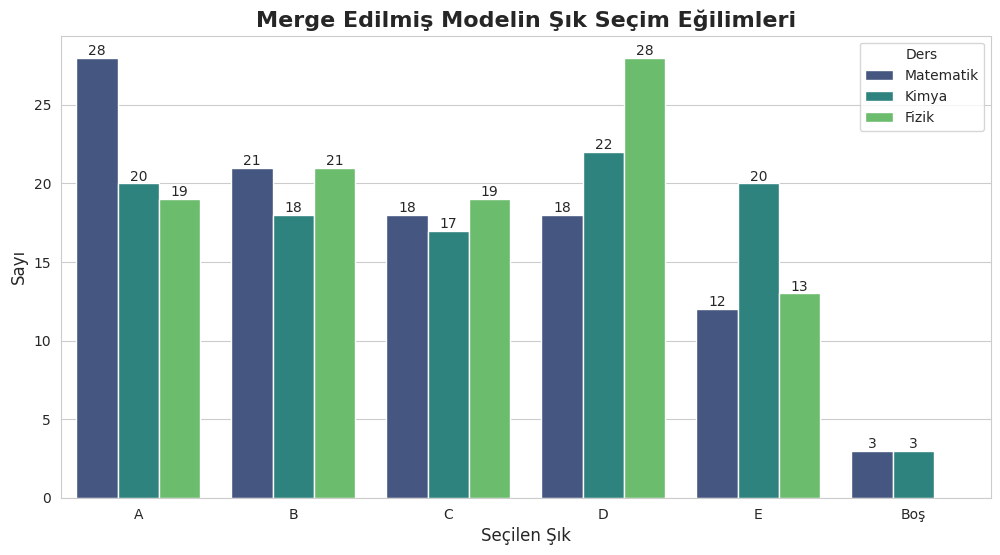

📊 Şık Dağılım Grafiği Kaydedildi: /content/drive/MyDrive/Proje_Yedekleri/Sik_Dagilimi_Analizi.png

🔍 YANLIŞ CEVAPLARDAN ÖRNEKLER (Her dersten 2 tane):

--- Matematik Hataları ---
❓ Soru: lim_{x→0} (√(1+3x) - 1) / x değeri kaçtır?...
✅ Gerçek: C | 🤖 Model: A
----------------------------------------
❓ Soru: f(x) = (ax + 3) / (x - 2) fonksiyonu veriliyor. f(x) fonksiyonu kendi tersine eş...
✅ Gerçek: D | 🤖 Model: B
----------------------------------------

--- Kimya Hataları ---
❓ Soru: Periyodik sistemin 2. periyodunda bulunan X, Y ve Z elementlerinin birinci iyonl...
✅ Gerçek: D | 🤖 Model: A
----------------------------------------
❓ Soru: Aşağıdaki tepkimelerden hangisi ayrışma (analiz) tepkimesidir?...
✅ Gerçek: C | 🤖 Model: B
----------------------------------------

--- Fizik Hataları ---
❓ Soru: Kütlesi 1 kg olan bir cisim sürtünmesiz yatay düzlemde 10 m/s hızla giderken, ay...
✅ Gerçek: B | 🤖 Model: D
----------------------------------------
❓ Soru: 6 Ω ve 3 Ω dirençler paralel ba

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm
import re
import torch

# 1. Dosya Yolları
base_path = "/content/drive/MyDrive/Proje_Yedekleri"
test_files = {
    "Matematik": f"{base_path}/mat_test.json",
    "Kimya":     f"{base_path}/kimya_test.json",
    "Fizik":     f"{base_path}/fizik_test.json"
}

# 2. Detaylı Test Fonksiyonu
def analyze_model_choices(model, tokenizer, test_files):
    all_results = []

    print("🕵️‍♂️ DETAYLI ANALİZ BAŞLIYOR...\n")

    prompt_temp = """Aşağıdaki soruyu çöz.
### Soru:
{}
### Seçenekler:
{}
### Çözüm ve Cevap:
"""

    for subject, path in test_files.items():
        if not os.path.exists(path):
            print(f"⚠️ {subject} dosyası bulunamadı, geçiliyor.")
            continue

        with open(path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        print(f"📘 {subject} Analiz Ediliyor ({len(data)} Soru)...")

        BATCH_SIZE = 16
        batches = [data[i:i + BATCH_SIZE] for i in range(0, len(data), BATCH_SIZE)]

        for batch in tqdm(batches, desc=subject):
            texts = []
            truths = []
            questions = []

            for item in batch:
                opts = item.get("options", [])
                opts_str = "\n".join([str(x) for x in opts]) if isinstance(opts, list) else str(opts)

                texts.append(prompt_temp.format(item["question"], opts_str))
                truths.append(str(item["correct"]).strip().upper())
                questions.append(item["question"])

            inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True).to("cuda")

            with torch.no_grad():
                outputs = model.generate(**inputs, max_new_tokens=512, pad_token_id=tokenizer.eos_token_id)

            decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            for i, text in enumerate(decoded):
                gen_text = text.replace(texts[i], "").strip()

                # Cevabı Yakala
                match = re.search(r"(?:Cevap|Seçenek|Yanıt|Doğru Cevap)[:\s-]*([A-E])", gen_text, re.IGNORECASE)
                if match:
                    ans = match.group(1).upper()
                else:
                    clean = gen_text.strip()
                    ans = clean[-1].upper() if clean and clean[-1].upper() in "ABCDE" else "Boş"

                is_correct = (ans == truths[i])

                all_results.append({
                    "Ders": subject,
                    "Soru": questions[i],
                    "Gerçek Cevap": truths[i],
                    "Model Cevabı": ans,
                    "Durum": "✅ Doğru" if is_correct else "❌ Yanlış",
                    "Tam Çıktı": gen_text[:200] + "..." # İnceleme için çıktının başı
                })

    return pd.DataFrame(all_results)

# 3. Analizi Çalıştır
df_analiz = analyze_model_choices(model, tokenizer, test_files)

# ========================================================
# 4. RAPORLAMA VE GÖRSELLEŞTİRME
# ========================================================

if not df_analiz.empty:
    # A) Excel Olarak Kaydet (Drive'a)
    excel_path = f"{base_path}/Fen_Bilimleri_Detayli_Hata_Raporu.xlsx"
    df_analiz.to_excel(excel_path, index=False)
    print(f"\n💾 Detaylı Rapor Kaydedildi: {excel_path}")

    # B) Grafik 1: Şık Dağılımı (Ders Bazlı)
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Sıralama: A, B, C, D, E, Boş
    order_list = ['A', 'B', 'C', 'D', 'E', 'Boş']

    ax = sns.countplot(data=df_analiz, x='Model Cevabı', hue='Ders',
                       order=[x for x in order_list if x in df_analiz['Model Cevabı'].unique()],
                       palette='viridis')

    plt.title('Merge Edilmiş Modelin Şık Seçim Eğilimleri', fontsize=16, fontweight='bold')
    plt.xlabel('Seçilen Şık', fontsize=12)
    plt.ylabel('Sayı', fontsize=12)
    plt.legend(title='Ders')

    # Barların üstüne sayı yaz
    for container in ax.containers:
        ax.bar_label(container)

    grafik_path = f"{base_path}/Sik_Dagilimi_Analizi.png"
    plt.savefig(grafik_path, dpi=300)
    plt.show()
    print(f"📊 Şık Dağılım Grafiği Kaydedildi: {grafik_path}")

    # C) Hatalı Sorulardan Örnekler Yazdır
    print("\n🔍 YANLIŞ CEVAPLARDAN ÖRNEKLER (Her dersten 2 tane):")
    for subject in test_files.keys():
        mistakes = df_analiz[(df_analiz['Ders'] == subject) & (df_analiz['Durum'] == '❌ Yanlış')]

        if not mistakes.empty:
            print(f"\n--- {subject} Hataları ---")
            for _, row in mistakes.head(2).iterrows():
                print(f"❓ Soru: {row['Soru'][:80]}...")
                print(f"✅ Gerçek: {row['Gerçek Cevap']} | 🤖 Model: {row['Model Cevabı']}")
                print("-" * 40)
        else:
            print(f"\n--- {subject}: HİÇ HATA YOK! 🎉 ---")

else:
    print("❌ Analiz edilecek veri oluşmadı.")